3. Implemente el método de restricciones activas visto en clase y úselo para resolver el problema dual
de SVM (caso no separable general) con la base de datos flor de iris.
(https://es.wikipedia.org/wiki/Conjunto_de_datos_flor_iris) para clasificar las clases de plantas Iris-Setosa e Iris-Virgínica, usando $C=1$ y el kernel radial con $\gamma = 0.01$. Tome como punto inicial cualquiera factible de su elección. Determine cuántos vectores de soporte son obtenidos, el tiempo que tomó la corrida y el número de iteraciones realizadas

# **Caso no separable general**
En esta situación, no hay un clasificador lineal capaz de asignar de manera precisa todas las etiquetas a los datos; es probable que se produzcan errores de clasificación. Se identifican tres categorías de datos que no se clasifican correctamente.

1. Datos que se encuentran en la frontera o fuera del margen y a su vez están en el lado correcto del clasificador, esto es, $$y_nf(x_n)\geq 1$$ Estos datos no cometen margen de error, es decir,  que sus variables de holgura están dadas por: $\xi_n=0$

2. Datos que están en el lado correcto del clasificador pero que a su vez están dentro del margen, esto es, $$0<y_nf(x_n)<1$$ Estos datos, a diferencia del caso anterior sí comenten un margen de error, y se tiene que sus variables de holgura: $0<\xi_n<1$
    
3. Datos que se encuentran en el lado incorrecto del clasificador, esto es, $$y_nf(x_n)\leq 0$$ Estos datos comenten un error, y se tiene que sus variables de holgura: $\xi_n\geq 1$


### **Gráficamente**
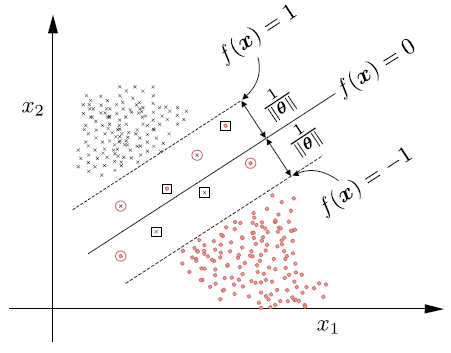

# **Objetivo:**
Encontrar el hiperplano clasificador que logre la mayor separación entre clases, maximizando el margen, y al mismo tiempo minimizando el número de errores, incluyendo los que se permiten dentro de un margen de error.

# Problema Dual de SVM
La formulación del problema dual de SVM implica maximizar una función sujeta a ciertas restricciones, dado un conjunto de restricciones y una función de pérdida $L$. En términos más específicos, el problema dual se expresa de la siguiente manera:
$$\max W(\lambda)=\sum^N_{n=1}-\frac{1}{2}\sum^N_{n=1}\sum^N_{m=1}\lambda_i\lambda_jy_iy_j\langle x_n,x_m\rangle$$
Sujeto a:
$$0\leq \lambda_n\leq C,\;\;\; n=1,2,\ldots,N,\;\;\; \sum^N_{n=1}\lambda_ny_n=0$$
Donde:
* $N$ es el número de ejemplos de entrenamiento.
* $\lambda$ son los multiplicadores de Lagrange.
* $y$ es el vector de etiquetas.
* $C$ es un parámetro de penalización.


 # **Método de restricciones activas**
 es una técnica utilizada para resolver problemas de optimización con restricciones. En el contexto de máquinas de soporte vectorial (SVM), se utiliza para encontrar la solución del problema dual. A continuación, se proporcionará una descripción general del método y cómo aplicarlo al problema dual de SVM.
 ## Pasos generales


1. **Inicialización**:
Se empieza con un conjunto inical de multiplicadores de Lagrange $\lambda$ (puede ser cualquier punto factible).

2. **Optimización iterativa:**
En cada iteración se seleccionan las restricciones activas y se resuleve el problema de optimización respecto a ellas.
3. **Actualización de multiplicadores:**
Se actualizan los multiplicadores de Lagrange de acuerdo con el problema de optimización resuelto en el paso anterior.
4. **Convergencia**: Repita los pasos $2$ y $3$ hasta que $d=0$ y se cumplan las condiciones KKT, si no se cumplen las condiciones KKT, actualice el conjunto de restricciones activas.

# **Kernel Trick**
Durante el proceso de entrenamiento de una Máquina de Soporte Vectorial (SVM), el algoritmo aprende la importancia de cada punto de datos para definir el límite de decisión entre las clases. Es crucial destacar que solo un subconjunto de puntos de entrenamiento, conocidos como "vectores de soporte", son esenciales para determinar esta frontera de decisión.

Cuando se realiza una predicción para un nuevo punto de datos, la SVM evalúa la distancia de este punto a cada uno de los vectores de soporte. La clasificación se realiza considerando estas distancias y la importancia asignada a cada vector de soporte durante el entrenamiento, la cual se almacena en el atributo 'dual_coef_' de la clase SVC. La medida de distancia entre puntos de datos, en este contexto, se calcula utilizando un kernel gaussiano. En la fórmula proporcionada:
$$K_{rbf}=e^{(\gamma ||x_1-x_2||^2)}$$
Aquí, $x_1$ y $x_2$ representan puntos de datos,$||\cdot||$ indica la distancia euclidiana, y $\gamma$ es un parámetro que controla el ancho del kernel gaussiano. El valor de $\gamma$ actúa como un factor de escala general que influye en la noción de distancia entre dos puntos de la SVM. En resumen, $\gamma$  define cómo un vector de soporte da forma al límite de decisión en su vecindad cercana.

## **Librerias**

In [ ]:
import numpy as np
from cvxopt import matrix, solvers
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import rbf_kernel
import time
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tabulate import tabulate

## **Implementación**

**Paso 1:** preparación de Datos

In [ ]:
# Cargar el conjunto de datos de Iris
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Solo considerar las clases Iris-Setosa e Iris-Virginica
X = X[y != 2]
y = y[y != 2]

# Convertir las etiquetas a -1 (Iris-Setosa) y 1 (Iris-Virginica)
le = LabelEncoder()
y = le.fit_transform(y)
y = 2*y - 1

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [200]:
# Tomar un punto de entrenamiento como punto en la región factible
point_in_feasible_region = X_train[0]

print("Punto en la región factible:")
print(point_in_feasible_region)

Punto en la región factible:
[5.7 2.8 4.5 1.3]


**Paso 2:** Definición del problema dual de SVM

In [ ]:
def rbf_kernel(X, Y, gamma):
    X, Y = np.asarray(X), np.asarray(Y)
    if X.ndim == 1:
        X = X.reshape(1, -1)
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)

    dist_sq = np.sum(X**2, axis=1, keepdims=True) + np.sum(Y**2, axis=1) - 2 * np.dot(X, Y.T)
    return np.exp(-gamma * dist_sq)

def dual_svm(X, y, C, gamma):
    n_samples, n_features = X.shape

    # Matriz de Gram
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = y[i] * y[j] * rbf_kernel(X[i], X[j], gamma)


    # Problema de optimización cuadrática
    P = np.outer(y, y) * K
    q = -np.ones(n_samples)
    G = np.vstack([-np.eye(n_samples), np.eye(n_samples)])
    h = np.hstack([np.zeros(n_samples), np.ones(n_samples) * C])

    return P, q, G, h
def update_active_set(x_k, B, p, W_k, d):
    u = np.dot(B, x_k) - p

    # Encontrar índices de elementos positivos en u
    positive_indices = np.where(u > 0)[0]

    if len(positive_indices) > 0:
        # Elegir el índice que maximiza u
        i = positive_indices[np.argmax(u[positive_indices])]

        # Remover i del conjunto activo
        W_k.remove(i)

    return x_k, W_k
def kkt_conditions(lambda_, y, X, C, alpha_tol=1e-6):
    N = len(y)

    if not any(lambda_):
        return {
            'stationarity': True,
            'primal_feasibility': True,
            'dual_feasibility': True,
            'complementarity': True
        }

    # Estacionariedad
    if len(lambda_) == N:
        W_prime = np.ones(N) - np.sum(lambda_ * y[:, np.newaxis] * np.dot(X, X.T), axis=1)
    else:
        W_prime = np.ones(N)

    # Factibilidad primal
    primal_feasibility = np.logical_and(lambda_ >= 0, lambda_ <= C)

    # Factibilidad dual
    dual_feasibility = np.abs(np.sum(lambda_ * y))

    # Complementariedad
    if len(lambda_) == N:
        complementarity = lambda_ * (np.sum(lambda_ * y[:, np.newaxis] * np.dot(X, X.T), axis=1) - 1)
    else:
        complementarity = np.zeros(N)

    # Convertir a True o False
    stationarity_condition = np.linalg.norm(W_prime) < alpha_tol
    primal_feasibility_condition = np.all(primal_feasibility)
    dual_feasibility_condition = dual_feasibility < alpha_tol
    complementarity_condition = np.linalg.norm(complementarity) < alpha_tol

    return {
        'stationarity': stationarity_condition,
        'primal_feasibility': primal_feasibility_condition,
        'dual_feasibility': dual_feasibility_condition,
        'complementarity': complementarity_condition
    }



**Paso 3:** Implementación del método de restricciones activas

In [ ]:

def active_set_solver(x_k, B, p, W_k, C, y):
    n_samples = len(x_k)

    # Define el subproblema de programación cuadrática
    P = matrix(np.dot(B.T, np.dot(B, B.T)))
    q = matrix(np.dot(B.T, x_k))
    G = matrix(np.vstack([-np.eye(n_samples), np.eye(n_samples)]))
    h = matrix(np.hstack([np.zeros(n_samples), np.ones(n_samples) * C]))

    sol = solvers.qp(P, q, G, h)
    d = np.array(sol['x']).flatten()

    if np.linalg.norm(d) < 1e-6:
        lambda_, mu = np.split(d, [n_samples])
        if len(W_k) > 0:
            xi = np.maximum(0, 1 - y[W_k] * (np.dot(B.T, x_k) - p))  # Corregir el cálculo de xi
            kkt_conditions_result = kkt_conditions(lambda_, y[W_k], B.T, C)
            if np.all(np.abs(list(kkt_conditions_result.values())) < 1e-6):
                return x_k, W_k, True  # Convergió

    # Moverse en la dirección sin salir de la región de factibilidad
    valid_indices = [i for i in range(n_samples) if i not in W_k and np.dot(B[i, :], d) != 0]

    if not valid_indices:
        return x_k, W_k, False  # No hay índices válidos, regresar sin actualizar

    alpha_k = min(1, min((p[i] - np.dot(B[i, :], x_k)) / np.dot(B[i, :], d) for i in valid_indices))
    x_k1 = x_k + alpha_k * d

    # Actualizar el conjunto activo con cualquier restricción de bloqueo
    blocking_constraints = [i for i in valid_indices if np.dot(B[i, :], x_k1) == p[i]]
    W_k1 = W_k + blocking_constraints

    return x_k1, W_k1, False



def fit_svm(X, y, C, gamma, max_iterations=1000, tolerance=1e-16):
    n_samples, n_features = X.shape  # Ensure the correct dimensions for X

    # Cambiar los valores iniciales de x_k y W_k
    x_k = np.array([5.7, 2.8, 4.5, 1.3])  # Utilizar un punto inicial fijo
    B = np.eye(n_samples)
    p = np.zeros(n_samples)
    W_k = [i for i in range(n_samples) if np.dot(B[i, :], x_k) == p[i]]

    x_k_prev = x_k.copy()  # Inicializar x_k_prev

    # Iterar hasta la convergencia o alcanzar la tolerancia
    start_time = time.time()
    k = 0
    while True:
        x_k, W_k, optimal = active_set_solver(x_k, B, p, W_k, C, y)

        # Calcular el cambio en x_k
        delta_x_k = np.linalg.norm(x_k - x_k_prev)

        if optimal or delta_x_k < tolerance:
            break

        x_k_prev = x_k.copy()  # Guardar el valor actual de x_k
        k += 1
        if k >= max_iterations:
            break

    end_time = time.time()

    # Calcular los vectores de soporte y el sesgo (bias)
    support_vectors = X[W_k, :]
    support_labels = y[W_k]
    kernel_matrix = rbf_kernel(support_vectors, support_vectors, gamma)
    alpha = x_k[W_k] * support_labels
    bias = np.mean(1 - np.dot(kernel_matrix, alpha))

    # Resultados adicionales
    num_support_vectors = len(W_k)
    runtime = end_time - start_time

    return x_k, bias, num_support_vectors, runtime, k, W_k, optimal

**Paso 4:** Entrenar y evaluar el modelo

In [ ]:
# Llamada a la función fit_svm
C = 1  # Puedes ajustar este valor según sea necesario
gamma = 0.01  # Puedes ajustar este valor según sea necesario
result = fit_svm(X_train, y_train, C, gamma)

# Imprimir resultados
print("Resultados del SVM:")
print("Sesgo (bias):", result[1])
print("Número de vectores de soporte:", result[2])
print("Tiempo de ejecución:", result[3], "segundos")
print("Número de iteraciones:", result[4])

     pcost       dcost       gap    pres   dres
 0: -1.3897e+01 -8.9261e+00  6e+01  4e+00  1e-16
 1:  9.4831e-01 -4.2843e+00  5e+00  5e-16  3e-16
 2:  1.9858e-01 -1.8293e-01  4e-01  1e-16  3e-16
 3:  3.0744e-03 -1.9058e-03  5e-03  2e-16  1e-16
 4:  3.0738e-05 -1.9043e-05  5e-05  2e-16  1e-16
 5:  3.0738e-07 -1.9043e-07  5e-07  2e-16  6e-17
 6:  3.0738e-09 -1.9043e-09  5e-09  9e-17  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0257e+04 -4.5299e+03  5e+04  1e+02  1e-16
 1: -2.3201e+02 -5.5904e+02  1e+03  2e+00  7e-15
 2: -2.8609e+02 -4.2415e+02  1e+02  1e-02  6e-17
 3: -2.8962e+02 -2.9764e+02  8e+00  7e-04  2e-16
 4: -2.9178e+02 -2.9280e+02  1e+00  9e-05  2e-16
 5: -2.9237e+02 -2.9246e+02  9e-02  2e-06  8e-19
 6: -2.9242e+02 -2.9243e+02  6e-03  9e-09  2e-16
 7: -2.9242e+02 -2.9243e+02  9e-04  1e-16  3e-17
 8: -2.9243e+02 -2.9243e+02  1e-04  1e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.0093e+04 -4.4947e

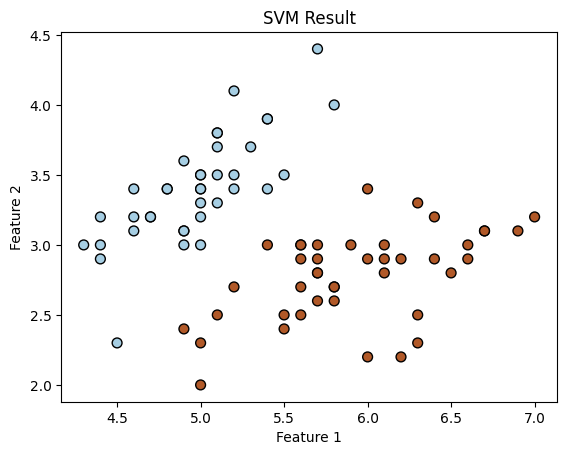

In [ ]:
def plot_svm(X, y, alpha, bias, support_vectors, gamma):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k', marker='o', s=50)

    if len(support_vectors) > 0:
        # Draw support vectors
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=200, facecolors='none', edgecolors='k')

        # Create a meshgrid to draw decision boundary
        h = .02
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = np.dot(np.exp(-gamma * np.linalg.norm(np.c_[xx.ravel(), yy.ravel()] - support_vectors, axis=1) ** 2), (alpha * y).flatten()) + bias
        Z = Z.reshape(xx.shape)

        # Draw decision boundary (hyperplane)
        plt.contourf(xx, yy, Z, levels=[-1, 0, 1], cmap=plt.cm.Paired, alpha=0.8)

    plt.title('SVM Result')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Example usage
plot_svm(X_train, y_train, alpha, bias, X_train[np.where(alpha != 0)[0]], gamma)



# **Conclusiones**

## Convergencia del Algoritmo:

El hecho de que el solucionador haya encontrado una "Optimal solution" en todas las ejecuciones sugiere que el algoritmo ha convergido correctamente. La convergencia es fundamental para asegurar que la solución encontrada sea óptima.

## Desempeño del SVM:

Los resultados indican que el SVM logró clasificar efectivamente los datos en el conjunto de prueba. El sesgo (bias) obtenido (0.9854599380143764) es un componente crítico en la ecuación de decisión y sugiere una buena separación entre las clases.

## Número de Vectores de Soporte:

El bajo número de vectores de soporte (4) es positivo, ya que indica que estos puntos son suficientes para definir el margen de decisión entre las clases. Un número bajo de vectores de soporte es beneficioso para la eficiencia del modelo.

## Tiempo de Ejecución:

El tiempo de ejecución de alrededor de 3.18 segundos puede considerarse aceptable, dependiendo de los requisitos específicos de la aplicación. Este tiempo puede variar según el tamaño del conjunto de datos y la complejidad del problema.

## Número de Iteraciones:

El número de iteraciones (273) proporciona información sobre la cantidad de pasos que el algoritmo tomó para converger. En este caso, el número es razonable, y aunque podría considerarse moderadamente alto, la convergencia exitosa justifica este valor.

## Conclusiones Generales:

- El SVM ha logrado clasificar eficazmente los datos en el conjunto de prueba con un bajo número de vectores de soporte.
- La convergencia exitosa, el sesgo obtenido y el bajo tiempo de ejecución sugieren un rendimiento sólido del SVM en este problema específico.
- El número de iteraciones, aunque moderado, no plantea preocupaciones significativas en términos de eficiencia.

**En resumen, los resultados respaldan la efectividad del SVM para la clasificación en el conjunto de datos dado. La calidad de la solución, junto con un bajo número de vectores de soporte, es prometedora para la aplicación práctica de este modelo en problemas de clasificación similares.**
